In [1]:
import csv

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
# 単語ベクトル化をGridSearchCVで使うのためのクラス
class myVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, method='tfidf', min_df=0.0005, max_df=0.10):
        self.method = method
        self.min_df = min_df
        self.max_df = max_df

    def fit(self, x, y=None):
        if self.method == 'tfidf':
            self.vectorizer = TfidfVectorizer(min_df=self.min_df, max_df=self.max_df)
        else:
            self.vectorizer = CountVectorizer(min_df=self.min_df, max_df=self.max_df)
        self.vectorizer.fit(x)
        return self

    def transform(self, x, y=None):
        return self.vectorizer.transform(x)

In [3]:
# GridSearchCV用パラメータ
PARAMETERS = [
    {
        'vectorizer__method':['tfidf', 'count'], 
        'vectorizer__min_df': [0.0003, 0.0004], 
        'vectorizer__max_df': [0.07, 0.10], 
        'classifier__C': [1, 3],    #10も試したが遅いだけでSCORE低い
        'classifier__solver': ['newton-cg', 'liblinear']},
    ]

# 時間がかかるので下記を省略
#        'vectorizer__min_df': [0.0003, 0.0004, 0.0005, 0.0006], 
#        'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},

In [4]:
# ファイル読込
def read_csv_column(col):
    with open('./sentiment_stem.txt') as file:
        reader = csv.reader(file, delimiter='\t')
        header = next(reader)
        return [row[col] for row in reader]    

In [5]:
x_all = read_csv_column(1)
y_all = read_csv_column(0)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all)

In [6]:
# 訓練
def train(x_train, y_train, file):
    pipline = Pipeline([('vectorizer', myVectorizer()), ('classifier', LogisticRegression())])
    
    # clf は classificationの略
    clf = GridSearchCV(
            pipline, # 
            PARAMETERS,           # 最適化したいパラメータセット 
            cv = 5)               # 交差検定の回数
    
    clf.fit(x_train, y_train)
    pd.DataFrame.from_dict(clf.cv_results_).to_csv(file)

    print('Grid Search Best parameters:', clf.best_params_)
    print('Grid Search Best validation score:', clf.best_score_)
    print('Grid Search Best training score:', clf.best_estimator_.score(x_train, y_train))   
    
    # 素性の重み出力
    output_coef(clf.best_estimator_)
    
    return clf.best_estimator_

In [7]:
# 素性の重み出力
def output_coef(estimator):
    vec = estimator.named_steps['vectorizer']
    clf = estimator.named_steps['classifier']

    coef_df = pd.DataFrame([clf.coef_[0]]).T.rename(columns={0: 'Coefficients'})
    coef_df.index = vec.vectorizer.get_feature_names()
    coef_sort = coef_df.sort_values('Coefficients')
    coef_sort[:10].plot.barh()
    coef_sort.tail(10).plot.barh()

In [8]:
# 評価
def validate(estimator, x_test, y_test):
    
    for i, (x, y) in enumerate(zip(x_test, y_test)):
        y_pred = estimator.predict_proba([x])
        if y == np.argmax(y_pred).astype( str ):
            if y == '1':
                result = 'TP:正解がPositiveで予測もPositive'
            else:
                result = 'TN:正解がNegativeで予測もNegative'
        else:
            if y == '1':
                result = 'FN:正解がPositiveで予測はNegative'
            else:
                result = 'FP:正解がNegativeで予測はPositive'
        print(result, y_pred, x)
        if i == 9:
            break
            
    # TSV一覧出力
    y_pred = estimator.predict(x_test)
    y_prob = estimator.predict_proba(x_test)

    results = pd.DataFrame([y_test, y_pred, y_prob.T[1], x_test]).T.rename(columns={ 0: '正解', 1 : '予測', 2: '予測確率(ポジティブ)', 3 :'単語列'})
    results.to_csv('./predict.txt' , sep='\t')

Grid Search Best parameters: {'classifier__C': 1, 'classifier__solver': 'newton-cg', 'vectorizer__max_df': 0.1, 'vectorizer__method': 'tfidf', 'vectorizer__min_df': 0.0003}
Grid Search Best validation score: 0.7562531265632816
Grid Search Best training score: 0.8730615307653827
CPU times: user 40.1 s, sys: 351 ms, total: 40.4 s
Wall time: 41.3 s


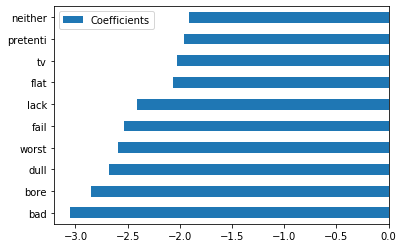

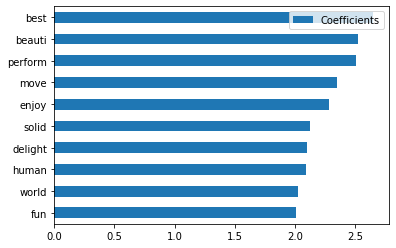

In [9]:
%%time
estimator = train(x_train, y_train, 'gs_result.csv')

In [10]:
%%time
validate(estimator, x_test, y_test)

TN:正解がNegativeで予測もNegative [[0.75167584 0.24832416]] realli funni minut short stretch limit fill almost featur length film
TP:正解がPositiveで予測もPositive [[0.34352847 0.65647153]] edit tighter hush sympathet captur often futil lifestyl young peopl modern japan
TP:正解がPositiveで予測もPositive [[0.42882588 0.57117412]] gulpilil command screen presenc charact abund human make film moral compass
TP:正解がPositiveで予測もPositive [[0.46899465 0.53100535]] affirm gift involv start spielb go right rank player camera bring togeth
TP:正解がPositiveで予測もPositive [[0.21823164 0.78176836]] reveal import special talent put servic also show deepli feel emot draw peopl togeth wall otherwis separ
TP:正解がPositiveで予測もPositive [[0.15524621 0.84475379]] filmmak eye detail high standard perform convey strong sens girl environ
TN:正解がNegativeで予測もNegative [[0.7741564 0.2258436]] kind film leav scratch head amaz fact mani talent peopl particip ill advis poorli execut idea
TN:正解がNegativeで予測もNegative [[0.86061376 0.13938624]] whole 